# Lab | Products review

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re,string
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation

In [6]:
df = pd.read_csv("./datasets/kindle_reviews_sampled.csv.zip")

In [8]:
df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,130918,B0063LXXOA,"[0, 0]",4,I liked this story going back to visist the fi...,"01 16, 2013",A66QR0ZQ8YET8,K. Floyd,Every Second Counts,1358294400
1,464192,B00BU67NY4,"[0, 0]",5,Not your typical love story. Popsicle was beyo...,"03 19, 2013",A9I2OPQT76SPD,LUV2READ,Raunchy!!,1363651200
2,420209,B00B8ZR41E,"[1, 1]",5,I loved these and so will you. They brought al...,"04 29, 2013",A3QGO0LC8C5VFV,misty morse,Absolutely loved these stories,1367193600
3,500564,B00CG6R4ZK,"[0, 0]",5,"Very nice cozy look at the next step for the ""...","10 27, 2013",A2QSRP25LFCQ7X,"Pam ""SMB,SLT""",Great tidbit,1382832000
4,796721,B00HY03FJM,"[0, 0]",5,Oh God I cried like a freaking baby. I have no...,"03 17, 2014",A35X4ALOWRAYB4,Legit,Oh my lawd,1395014400


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78610 entries, 0 to 78609
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      78610 non-null  int64 
 1   asin            78610 non-null  object
 2   helpful         78610 non-null  object
 3   overall         78610 non-null  int64 
 4   reviewText      78609 non-null  object
 5   reviewTime      78610 non-null  object
 6   reviewerID      78610 non-null  object
 7   reviewerName    78338 non-null  object
 8   summary         78600 non-null  object
 9   unixReviewTime  78610 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 6.0+ MB


In [6]:
#Delete all features except overall, reviewText and summary

In [7]:
df.isna().sum()

overall        0
reviewText    22
summary        1
dtype: int64

In [9]:
df.head()

,overall,reviewText,summary
0,5,I enjoy vintage books and movies so I enjoyed ...,Nice vintage story
1,4,This book is a reissue of an old one; the auth...,Different...
2,4,This was a fairly interesting read. It had ol...,Oldie
3,5,I'd never read any of the Amy Brewster mysteri...,I really liked it.
4,4,"If you like period pieces - clothing, lingo, y...",Period Mystery


In [10]:
#combine the reviewText and the summary features into one feature called reviewText - Be sure to add a space (' ') to seperate the two

In [11]:
df.isna().sum()

overall        0
reviewText    23
dtype: int64

In [12]:
df['reviewText'].fillna("",inplace = True)

In [13]:
df.head()

,overall,reviewText
0,5,I enjoy vintage books and movies so I enjoyed ...
1,4,This book is a reissue of an old one; the auth...
2,4,This was a fairly interesting read. It had ol...
3,5,I'd never read any of the Amy Brewster mysteri...
4,4,"If you like period pieces - clothing, lingo, y..."


In [14]:
df.overall.value_counts()

5    575264
4    254013
3     96194
2     34130
1     23018
Name: overall, dtype: int64

In [15]:
def review_sentiment(rating): #This function should return 1 or 0
    # Write a the code to replace rating of 1,2,3 with 0(not good) and 4,5 with 1(good) 
    # YOUR CODE

In [16]:
#Transform the overal feature based on the review_sentiment above. Hint: Use the apply method on the Series 'overall'
df['overall'] = #YOUR CODE df.overall.apply(review_sentiment)

In [17]:
df.head()

,overall,reviewText
0,1,I enjoy vintage books and movies so I enjoyed ...
1,1,This book is a reissue of an old one; the auth...
2,1,This was a fairly interesting read. It had ol...
3,1,I'd never read any of the Amy Brewster mysteri...
4,1,"If you like period pieces - clothing, lingo, y..."


In [18]:
df.overall.value_counts()

1    829277
0    153342
Name: overall, dtype: int64

In [19]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [20]:
def clean_text(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            word = i.strip().lower()
            final_text.append(word)
    return " ".join(final_text) 

In [21]:
df['reviewText'] = df['reviewText'].apply(clean_text)

In [22]:
x_train,x_test,y_train,y_test = #Use train_test_split function and assign 80% data to the training set and 20% to the test set.
#Should you consider a stratify split? Why?

In [23]:
cv=CountVectorizer(min_df=0,max_df=1,ngram_range=(1,1))
#transformed train reviews
cv_train_reviews=cv.fit_transform(x_train)
#transformed test reviews
cv_test_reviews=cv.transform(x_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (736964, 135828)
BOW_cv_test: (245655, 135828)


In [24]:
#Initialize and fit a multinomial Naive Bayes model to the training set

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [25]:
#Return the predictions on the test set using the accuracy_score and/or other metrics of interest

0.8431295923144247

In [26]:
#Use the classification_report function and print the result using the predicted results on the test set

              precision    recall  f1-score   support

           0       0.27      0.00      0.00     38383
           1       0.84      1.00      0.91    207272

    accuracy                           0.84    245655
   macro avg       0.56      0.50      0.46    245655
weighted avg       0.75      0.84      0.77    245655



In [27]:
cm_cv = confusion_matrix(y_test,mnb_pred)
cm_cv

array([[    89,  38294],
       [   242, 207030]])

In [28]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

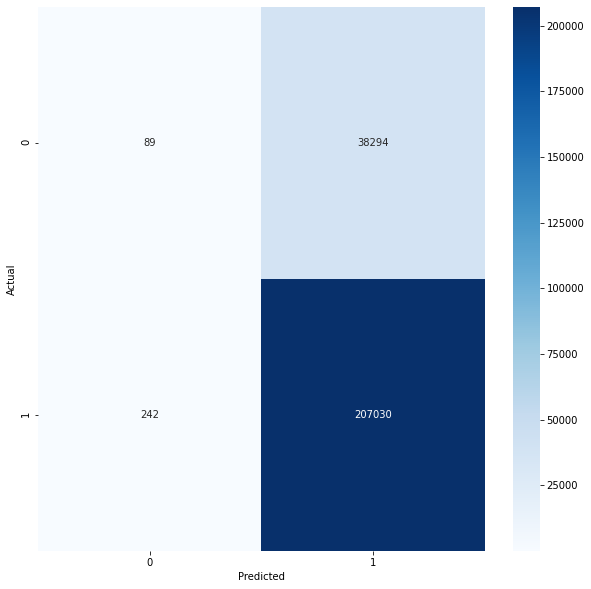

In [29]:
#Create a heat map to visualize the confusion matrix